In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import ultralytics
from ultralytics import RTDETR
ultralytics.checks()

import keras_core

import cv2
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

from math import sin, cos, tan, pi
from geographiclib.geodesic import Geodesic


Ultralytics YOLOv8.0.207  Python-3.11.5 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Setup complete  (24 CPUs, 63.9 GB RAM, 1067.9/1907.7 GB disk)


Using PyTorch backend.


# Get the list used by the classifier model

In [3]:
classifier_list = ['A10',
                   'A400M',
                   'AG600',
                   'AV8B',
                   'B1',
                   'B2',
                   'B52',
                   'Be200',
                   'C130',
                   'C17',
                   'C2',
                   'C5',
                   'E2',
                   'E7',
                   'EF2000',
                   'F117',
                   'F14',
                   'F15',
                   'F16',
                   'F18',
                   'F22',
                   'F35',
                   'F4',
                   'J20',
                   'JAS39',
                   'MQ9',
                   'Mig31',
                   'Mirage2000',
                   'P3',
                   'RQ4',
                   'Rafale',
                   'SR71',
                   'Su34',
                   'Su57',
                   'Tornado',
                   'Tu160',
                   'Tu95',
                   'U2',
                   'US2',
                   'V22',
                   'Vulcan',
                   'XB70',
                   'YF23']

# Load the models

In [4]:
cls_model = keras_core.saving.load_model("ac_ident_model_adadelta.keras", custom_objects=None, compile=True, safe_mode=True)

det_model = RTDETR(model="runs/detect/RTDETR_3/weights/best.pt")

# Test using this image:

![test](Assets\test_imgs\f_15.jpg)

### A single F-15E flying over the end of the runway at Andersen AFB

# Predict bounding box

In [5]:
det_pred = det_model("Assets/test_imgs/f_15.jpg")


image 1/1 e:\GA DSIF\Capstone\Assets\test_imgs\f_15.jpg: 1280x1280 1 F15, 34.0ms
Speed: 8.0ms preprocess, 34.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


In [6]:
for r in det_pred:
    print(r.boxes.xywh)

tensor([[1741.7869,  668.3191,   89.3680,   70.5939]], device='cuda:0')


# Save bounding box locations, centre of box, and size of box

In [7]:
for r in det_pred:
    x_ctr = r.boxes.xywh[0][0]
    y_ctr = r.boxes.xywh[0][1]
    x_sz = r.boxes.xywh[0][2]
    y_sz = r.boxes.xywh[0][3]
    box_left = int(np.round(r.boxes.xyxy[0][0].cpu()))
    box_right = int(np.round(r.boxes.xyxy[0][2].cpu()))
    box_bottom = int(np.round(r.boxes.xyxy[0][1].cpu()))
    box_top = int(np.round(r.boxes.xyxy[0][3].cpu()))

In [8]:
box_bottom

633

In [9]:
box_top

704

In [10]:
box_left

1697

In [11]:
box_right

1786

# Check to make sure model has cropped the right thing

### disregard colouring as cv2 uses BGR instead of RGB - models take RGB

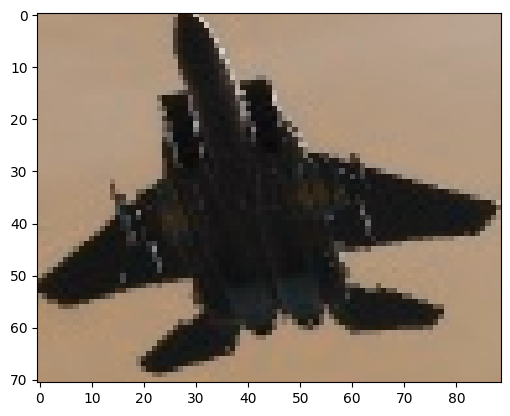

In [12]:
img = cv2.imread("Assets/test_imgs/f_15.jpg")
crop_img = img[box_bottom:box_top, box_left:box_right]
plt.imshow(crop_img)

### Model has picked up the jet

# Get datetime to name the file

In [13]:
time_now = datetime.datetime.now()

dt_str = time_now.strftime("%Y%m%d_%H%M%S")

In [14]:
dt_str

'20231125_003759'

# Save the cropped image

In [15]:
cv2.imwrite(f"cropped_pred\{dt_str}.jpg", crop_img)

True

# Load cropped image in format appropriate to classification model

In [16]:
crop_1 = keras_core.utils.load_img(f"cropped_pred\{dt_str}.jpg",
                                    color_mode="rgb",
                                    target_size=(256, 256),
                                    interpolation="nearest",
                                    keep_aspect_ratio=False,
                                    )


In [17]:
input_arr = keras_core.utils.img_to_array(crop_1)
input_arr = np.array([input_arr])
cls_pred = cls_model.predict(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [18]:
cls_num = cls_pred.argmax()

# Check that it made the right classification

In [19]:
classifier_list[cls_num]

'F15'

In [20]:
pred_type = classifier_list[cls_num]

# Time to write the positional calculation functions

### Constants

In [21]:
FOV = 78

# Get degrees per pixel

DPP = (FOV / 2560)

# vertical pixel count

VPIX = 1440

# horizontal pixel count

HPIX = 2560

In [22]:
df = pd.read_csv("Assets/type_data.csv")

In [23]:
df

,type,length,wingspan,spanxlength
0,A10,16.260,17.530,16.8950
1,A400M,45.100,42.400,43.7500
2,AG600,36.900,38.800,37.8500
3,AV8B,14.120,9.250,11.6850
4,B1,45.000,42.000,43.5000
5,B2,21.000,52.400,36.7000
6,B52,48.500,56.400,52.4500
7,Be200,32.000,32.800,32.4000
8,C130,29.790,40.410,35.1000
9,C17,53.000,51.755,52.3775


## Distance

In [24]:
def get_distance(type_df, type, pix_width, dpp=DPP):
    spanxlength = type_df.loc[type_df["type"] == type, "spanxlength"].iloc[0]
    trg_opp = (spanxlength / 2)
    width = float(pix_width.cpu())
    trg_theta = ((width*dpp) / 2)
    trg_adj = (trg_opp / (tan((trg_theta * pi) / 180)))
    return trg_adj

In [25]:
dst = get_distance(df, pred_type, x_sz)

In [26]:
dst

341.7724758071199

# Target Altitude

In [27]:
def get_altitude(distance, cam_elev, cam_alt, y_ctr, ypix=VPIX, dpp=DPP):
    y_ctr = (float(y_ctr.cpu()) * dpp)
    bottom_y_cam = cam_elev - ((ypix/2) * dpp)
    trg_theta = bottom_y_cam + y_ctr
    trg_hyp = distance
    trg_opp = (trg_hyp * (sin((trg_theta * pi) / 180)))
    return ((trg_opp * 3.28084) + cam_alt)


In [28]:
get_altitude(dst, 59, 640, y_ctr)

1584.909723390308

In [29]:
tgt_alt = get_altitude(dst, 59, 640, y_ctr)

## The aircraft was set to fly at 1500 ft - the estimate is only 84 feet off which is nothing in aviation

# Get coordinates

### Start with horizontal distance

In [30]:
def get_horizontal_distance(distance, cam_elev, y_ctr, ypix=VPIX, dpp=DPP):
    y_ctr = (float(y_ctr.cpu()) * dpp)
    bottom_y_cam = cam_elev - ((ypix/2) * dpp)
    trg_theta = bottom_y_cam + y_ctr
    trg_hyp = distance
    trg_adj = (trg_hyp * (cos((trg_theta * pi) / 180)))
    return trg_adj

In [31]:
get_horizontal_distance(dst, 59, y_ctr)

184.0096297779252

In [32]:
hz_dst = get_horizontal_distance(dst, 59, y_ctr)

### Then get the azimuth

In [33]:
def get_azimuth(cam_az, x_ctr, xpix=HPIX, dpp=DPP):
    x_ctr = (float(x_ctr.cpu()) * dpp)
    left_x_cam = cam_az - ((xpix / 2) * dpp)
    tgt_az = (left_x_cam + x_ctr) % 360
    return(tgt_az)

In [34]:
get_azimuth(37, x_ctr)

51.07006855010986

In [35]:
az = get_azimuth(37, x_ctr)

### Solve the geodesic problem

In [36]:
# function to convert dms to dd

def dms_to_dd(d, m, s, NE):
    dd = d + float(m)/60 + float(s)/3600
    if NE == "S" or NE == "W":
        dd *= -1
    return dd

In [37]:
def get_tgt_coords(hz_dst, az, cam_lat, cam_long):
    geo_obj = Geodesic.WGS84.Direct(cam_lat, cam_long, az, hz_dst)
    tgt_lat = geo_obj["lat2"]
    tgt_lon = geo_obj["lon2"]
    return (tgt_lat, tgt_lon)

In [38]:
cam_lat = dms_to_dd(13, 35, 28, "N")

cam_long = dms_to_dd(144, 56, 47, "E")

In [39]:
cam_lat

13.591111111111111

In [40]:
get_tgt_coords(hz_dst, az, cam_lat, cam_long)

(13.592156214424612, 144.94771157856493)

In [41]:
tgt_coords = get_tgt_coords(hz_dst, az, cam_lat, cam_long)

# Check where it thinks the jet is:

![tgt_loc](Assets\gmaps\tgt_1_loc.jpg)

# Check camera position

![tgt_loc](Assets\gmaps\cam_loc.jpg)

# The system works:

In [42]:
# Target coordinates:

tgt_coords

(13.592156214424612, 144.94771157856493)

In [43]:
# Target altitude:

tgt_alt

1584.909723390308

In [44]:
# Target type:

pred_type

'F15'

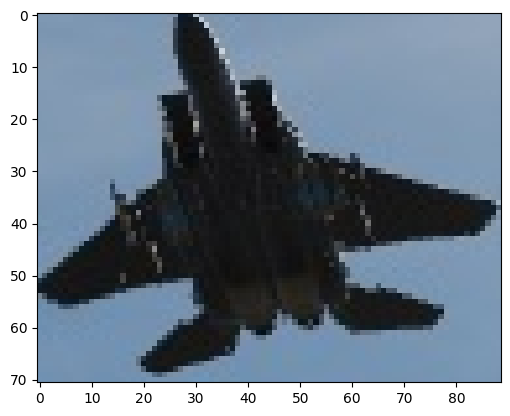

In [45]:
# What the target looks like:

img = cv2.imread("Assets/test_imgs/f_15.jpg")
crop_img = img[box_bottom:box_top, box_left:box_right]
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
plt.imshow(crop_img)

# Next step - build UI + integrate this into a coherent program